# Death Proximity Classification — Featureless Model

Ce notebook entraîne un modèle pour prédire si un segment de comportement
est **proche de la mort** en n’utilisant que les trajectoires brutes
(Speed, turning angle) — *sans* les features hand-crafted.

Les labels "close_to_death" sont définis **exactement comme dans le
notebook minimal-features** : pour chaque worm, on reconstruit
`segment_index`, on calcule `segments_from_end`, puis on pose

> close_to_death = 1 si `segments_from_end <= PROXIMITY_THRESHOLD` segments.



In [3]:
import os
import glob
import re

import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedGroupKFold, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    precision_recall_curve,
)
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

from xgboost import XGBClassifier  # pip install xgboost si besoin

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6, 4)

# --------------------
# Paths
# --------------------
SEGMENTS_DIR = "preprocessed_data/segments"   # dossier avec les segments .csv

# --------------------
# Segment parameters
# --------------------
SEGMENT_LENGTH = 900          # nb de frames par segment (comme dans le préproc)
PROXIMITY_THRESHOLD = 20      # nombre de segments depuis la fin (comme min_features)

# Colonnes utilisées dans les CSV de segments
# Adapter si le nom change dans tes fichiers
FEATURE_COLS = ["Speed", "turning_angle"]
SOURCE_FILE_COL = "source_file"      # identifiant du worm / fichier original
SEGMENT_IDX_COL = "Segment_index"    # index du segment pour ce worm
TIME_COL = "GlobalFrame"             # temps global, pour trier les frames


helper pour extraire les infos d'un fichier de segment

In [4]:
def load_segment_file(path):
    """
    Charge un fichier de segment et renvoie :
      - features : array (T, 2) avec  [Speed, turning_angle]
      - original_file : identifiant du worm (source_file)
      - segment_index : index du segment pour ce worm
    """
    df = pd.read_csv(path)

    # Vérifications de base
    for c in [TIME_COL, SOURCE_FILE_COL, SEGMENT_IDX_COL] + FEATURE_COLS:
        if c not in df.columns:
            raise RuntimeError(f"Column '{c}' missing in {os.path.basename(path)}")

    # ordre temporel
    df = df.sort_values(TIME_COL)

    original_file = str(df[SOURCE_FILE_COL].iloc[0])
    segment_idx = int(df[SEGMENT_IDX_COL].iloc[0])

    # features brutes
    raw = df[FEATURE_COLS].to_numpy()

    # pad / tronque à SEGMENT_LENGTH
    if raw.shape[0] < SEGMENT_LENGTH:
        pad_len = SEGMENT_LENGTH - raw.shape[0]
        pad = np.tile(raw[-1:, :], (pad_len, 1))
        raw = np.vstack([raw, pad])
    elif raw.shape[0] > SEGMENT_LENGTH:
        raw = raw[:SEGMENT_LENGTH, :]

    return raw, original_file, segment_idx


charger tous les segments et construire un data frame

In [5]:
segment_files = sorted(glob.glob(os.path.join(SEGMENTS_DIR, "*.csv")))
print(f"Found {len(segment_files)} segment files in {SEGMENTS_DIR}")

all_features = []
meta_rows = []

for path in segment_files:
    filename = os.path.basename(path)
    feats, original_file, seg_idx = load_segment_file(path)

    all_features.append(feats)
    meta_rows.append({
        "filename": filename,
        "original_file": original_file,
        "segment_index": seg_idx,
    })

meta_df = pd.DataFrame(meta_rows)
print(meta_df.head())
print("Nb segments loaded:", len(meta_df))


Found 8150 segment files in preprocessed_data/segments
                                            filename  \
0  coordinates_highestspeed_20240827_10_1_with_ti...   
1  coordinates_highestspeed_20240827_10_1_with_ti...   
2  coordinates_highestspeed_20240827_10_1_with_ti...   
3  coordinates_highestspeed_20240827_10_1_with_ti...   
4  coordinates_highestspeed_20240827_10_1_with_ti...   

                                       original_file  segment_index  
0  coordinates_highestspeed_20240827_10_1_with_ti...              0  
1  coordinates_highestspeed_20240827_10_1_with_ti...              1  
2  coordinates_highestspeed_20240827_10_1_with_ti...             10  
3  coordinates_highestspeed_20240827_10_1_with_ti...             11  
4  coordinates_highestspeed_20240827_10_1_with_ti...             12  
Nb segments loaded: 8150


recreer segment_from_end et labels 

In [6]:
# Pour chaque worm (original_file), max index de segment
max_seg = meta_df.groupby("original_file")["segment_index"].max()

# segments_from_end = max_seg_for_this_worm - current_segment_index
meta_df["segments_from_end"] = meta_df.apply(
    lambda row: max_seg[row["original_file"]] - row["segment_index"],
    axis=1
)

def make_labels_from_segments(df, threshold_segments: int) -> pd.Series:
    """
    Même définition que dans death_min_features:
    near-death (1) si segments_from_end <= threshold_segments.
    """
    return (df["segments_from_end"] <= threshold_segments).astype(int)

meta_df["close_to_death"] = make_labels_from_segments(meta_df, PROXIMITY_THRESHOLD)
y = meta_df["close_to_death"].values
groups = meta_df["original_file"].values

print("Label distribution (0=not near-death, 1=near-death):", np.bincount(y))
meta_df[["segment_index", "segments_from_end", "close_to_death"]].head()


Label distribution (0=not near-death, 1=near-death): [6016 2134]


,segment_index,segments_from_end,close_to_death
0,0,54,0
1,1,53,0
2,10,44,0
3,11,43,0
4,12,42,0


Mise en forme de X: flatten (N,900*2)

In [7]:
X_raw = np.stack(all_features)      # (N, 900, 2)
N, T, F = X_raw.shape
print(f"X_raw shape: {X_raw.shape} (N={N}, T={T}, F={F})")

# Flatten 900x2 -> 1800-dim vector
X_flat = X_raw.reshape(N, T * F)
print("X_flat shape:", X_flat.shape)


X_raw shape: (8150, 900, 2) (N=8150, T=900, F=2)
X_flat shape: (8150, 1800)


helper split par worm

In [8]:
def group_train_test_split(X, y, groups, test_size=0.2, random_state=123):
    """
    Split indices into train/test using GroupShuffleSplit (grouped by worm).
    """
    gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    train_idx, test_idx = next(gss.split(X, y, groups))
    return train_idx, test_idx


split train/val/test + standardscaler

In [9]:
# First split: train (70%) vs temp (30%)
gss1 = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_idx, temp_idx = next(gss1.split(X_flat, y, groups=groups))

# Second split: temp -> val (15%) + test (15%)
gss2 = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=43)
val_idx_temp, test_idx_temp = next(gss2.split(X_flat[temp_idx], y[temp_idx], groups=groups[temp_idx]))

val_idx  = temp_idx[val_idx_temp]
test_idx = temp_idx[test_idx_temp]

print(f"Train: {len(train_idx)}  Val: {len(val_idx)}  Test: {len(test_idx)}")
print("Train label distribution:", np.bincount(y[train_idx]))
print("Val   label distribution:", np.bincount(y[val_idx]))
print("Test  label distribution:", np.bincount(y[test_idx]))

X_train, X_val, X_test = X_flat[train_idx], X_flat[val_idx], X_flat[test_idx]
y_train, y_val, y_test = y[train_idx], y[val_idx], y[test_idx]

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_val_sc   = scaler.transform(X_val)
X_test_sc  = scaler.transform(X_test)


Train: 5726  Val: 1275  Test: 1149
Train label distribution: [4252 1474]
Val   label distribution: [949 326]
Test  label distribution: [815 334]


baseline gradientboosting (tres long a run: 25 min )
tout diviser par 2 pour que moins long 

In [10]:
gb = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)

gb.fit(X_train_sc, y_train)

# Validation
proba_val = gb.predict_proba(X_val_sc)[:, 1]
pred_val  = (proba_val >= 0.5).astype(int)

acc_val = accuracy_score(y_val, pred_val)
f1_val  = f1_score(y_val, pred_val)
auc_val = roc_auc_score(y_val, proba_val)

print("=== Validation performance (threshold=0.5) ===")
print(f"ACC={acc_val:.3f} | F1={f1_val:.3f} | AUC={auc_val:.3f}")

# Test
proba_test = gb.predict_proba(X_test_sc)[:, 1]
pred_test  = (proba_test >= 0.5).astype(int)

acc_test = accuracy_score(y_test, pred_test)
f1_test  = f1_score(y_test, pred_test)
auc_test = roc_auc_score(y_test, proba_test)

print("\n=== Test performance (threshold=0.5) ===")
print(f"ACC={acc_test:.3f} | F1={f1_test:.3f} | AUC={auc_test:.3f}")


=== Validation performance (threshold=0.5) ===
ACC=0.781 | F1=0.510 | AUC=0.818

=== Test performance (threshold=0.5) ===
ACC=0.788 | F1=0.564 | AUC=0.848


CV(stratifiedGroupeKFold) long a run = 168 min pour uniquement 2 folds -> a run cette nuit 

In [11]:
def evaluate_featureless_cv(X_flat, y, groups, n_splits=5, random_state=42):
    """
    Cross-validate a featureless GradientBoosting model using StratifiedGroupKFold.
    """
    cv = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    clf = Pipeline([
        ("scaler", StandardScaler()),
        ("gb", GradientBoostingClassifier(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=6,
            random_state=random_state
        ))
    ])

    accs, f1s, aucs = [], [], []

    for fold, (train_idx, test_idx) in enumerate(cv.split(X_flat, y, groups)):
        print(f"\n=== Fold {fold+1}/{n_splits} ===")
        X_tr, X_te = X_flat[train_idx], X_flat[test_idx]
        y_tr, y_te = y[train_idx], y[test_idx]

        clf.fit(X_tr, y_tr)
        proba = clf.predict_proba(X_te)[:, 1]
        preds = (proba >= 0.5).astype(int)

        acc = accuracy_score(y_te, preds)
        f1  = f1_score(y_te, preds)
        auc = roc_auc_score(y_te, proba)

        print(f"ACC={acc:.3f} | F1={f1:.3f} | AUC={auc:.3f}")

        accs.append(acc); f1s.append(f1); aucs.append(auc)

    return {
        "ACC_mean": np.mean(accs), "ACC_std": np.std(accs),
        "F1_mean":  np.mean(f1s),  "F1_std":  np.std(f1s),
        "AUC_mean": np.mean(aucs), "AUC_std": np.std(aucs),
    }

cv_results_featureless = evaluate_featureless_cv(X_flat, y, groups)
cv_results_featureless



=== Fold 1/5 ===
ACC=0.817 | F1=0.611 | AUC=0.884

=== Fold 2/5 ===
ACC=0.767 | F1=0.494 | AUC=0.836

=== Fold 3/5 ===
ACC=0.759 | F1=0.455 | AUC=0.825

=== Fold 4/5 ===
ACC=0.771 | F1=0.540 | AUC=0.813

=== Fold 5/5 ===
ACC=0.791 | F1=0.543 | AUC=0.839


{'ACC_mean': 0.7813317570018867,
 'ACC_std': 0.020922166856300602,
 'F1_mean': 0.5285601636440436,
 'F1_std': 0.05276301842128762,
 'AUC_mean': 0.8394958034856149,
 'AUC_std': 0.02396410279250027}

Model Comparison (GB/LogReg/LinearSVM/XGBoost)  temps de run: 22 min


In [12]:
print("=== Model comparison on flattened raw segments (featureless) ===")

train_idx_mc, test_idx_mc = group_train_test_split(
    X_flat, y, groups, test_size=0.2, random_state=123
)

X_train_mc, X_test_mc = X_flat[train_idx_mc], X_flat[test_idx_mc]
y_train_mc, y_test_mc = y[train_idx_mc], y[test_idx_mc]

scaler_mc = StandardScaler()
X_train_mc_sc = scaler_mc.fit_transform(X_train_mc)
X_test_mc_sc  = scaler_mc.transform(X_test_mc)

models = {
    "GradientBoosting": GradientBoostingClassifier(
        n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42
    ),
    "LogisticRegression": LogisticRegression(
        max_iter=500, class_weight="balanced", random_state=42
    ),
    "LinearSVM": CalibratedClassifierCV(
        LinearSVC(C=1.0, class_weight="balanced", random_state=42),
        method="sigmoid", cv=3
    ),
    "XGBoost": XGBClassifier(
        n_estimators=300,
        max_depth=4, #changer
        learning_rate=0.05, #changer 
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        random_state=42
    ),#faire gridsearch sur les parametres pour optimiser le truc 
}

results_models_featless = []

for name, model in models.items():
    print(f"\n--- Training {name} ---")
    model.fit(X_train_mc_sc, y_train_mc)

    proba = model.predict_proba(X_test_mc_sc)[:, 1]
    preds = (proba >= 0.5).astype(int)

    acc = accuracy_score(y_test_mc, preds)
    f1  = f1_score(y_test_mc, preds)
    auc = roc_auc_score(y_test_mc, proba)

    print(f"{name:15s} | ACC={acc:.3f} | F1={f1:.3f} | AUC={auc:.3f}")

    results_models_featless.append({"model": name, "ACC": acc, "F1": f1, "AUC": auc})

results_models_featless_df = pd.DataFrame(results_models_featless)
results_models_featless_df


=== Model comparison on flattened raw segments (featureless) ===

--- Training GradientBoosting ---
GradientBoosting | ACC=0.772 | F1=0.493 | AUC=0.814

--- Training LogisticRegression ---
LogisticRegression | ACC=0.666 | F1=0.444 | AUC=0.686

--- Training LinearSVM ---


/Users/leontine/anaconda3/envs/celegans/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/leontine/anaconda3/envs/celegans/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/leontine/anaconda3/envs/celegans/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVM       | ACC=0.756 | F1=0.000 | AUC=0.664

--- Training XGBoost ---
XGBoost         | ACC=0.776 | F1=0.506 | AUC=0.814


,model,ACC,F1,AUC
0,GradientBoosting,0.771930,0.493082,0.814448
1,LogisticRegression,0.665535,0.444026,0.686235
2,LinearSVM,0.755518,0.000000,0.663611
3,XGBoost,0.776457,0.505632,0.813551


tester random forest et d'autres SVM (pas lineaire->celui ou tu peux choisir les dimensions)


threshold tuning (optimiser F1 sur (proba))

In [13]:
print("=== Threshold tuning for featureless GradientBoosting ===")

# Outer split: train+val vs test, by worm
gss_outer = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=11)
trainval_idx, test_idx_thr = next(gss_outer.split(X_flat, y, groups=groups))

X_trainval, X_test_thr = X_flat[trainval_idx], X_flat[test_idx_thr]
y_trainval, y_test_thr = y[trainval_idx], y[test_idx_thr]
groups_trainval = groups[trainval_idx]

# Inner split: train vs val
gss_inner = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=22)
inner_train_idx, val_idx_thr = next(gss_inner.split(X_trainval, y_trainval, groups=groups_trainval))

X_inner_train, X_val_thr = X_trainval[inner_train_idx], X_trainval[val_idx_thr]
y_inner_train, y_val_thr  = y_trainval[inner_train_idx], y_trainval[val_idx_thr]

scaler_thr = StandardScaler()
X_inner_train_sc = scaler_thr.fit_transform(X_inner_train)
X_val_thr_sc     = scaler_thr.transform(X_val_thr)
X_test_thr_sc    = scaler_thr.transform(X_test_thr)

gb_thr = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)

gb_thr.fit(X_inner_train_sc, y_inner_train)
val_proba = gb_thr.predict_proba(X_val_thr_sc)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_val_thr, val_proba)
f1s = 2 * (precision * recall) / (precision + recall)
f1s = f1s[:-1]  # dernière valeur sans threshold

best_idx = np.nanargmax(f1s)
best_thr = thresholds[best_idx]

print(f"Best threshold (validation, max F1): {best_thr:.3f}")
print(f"Validation F1 at best threshold: {f1s[best_idx]:.3f}")

# Retrain on full trainval and evaluate on test
gb_thr.fit(scaler_thr.transform(X_trainval), y_trainval)
test_proba = gb_thr.predict_proba(X_test_thr_sc)[:, 1]

preds_default = (test_proba >= 0.5).astype(int)
preds_best    = (test_proba >= best_thr).astype(int)

acc_default = accuracy_score(y_test_thr, preds_default)
f1_default  = f1_score(y_test_thr, preds_default)
auc_default = roc_auc_score(y_test_thr, test_proba)

acc_best = accuracy_score(y_test_thr, preds_best)
f1_best  = f1_score(y_test_thr, preds_best)

print("\n=== Test performance (threshold=0.5) ===")
print(f"ACC={acc_default:.3f} | F1={f1_default:.3f} | AUC={auc_default:.3f}")

print("\n=== Test performance (optimized threshold) ===")
print(f"ACC={acc_best:.3f} | F1={f1_best:.3f} | AUC={auc_default:.3f} (AUC unchanged)")


=== Threshold tuning for featureless GradientBoosting ===


/var/folders/v0/d9g9nzhn7kz37clx5cr7kglc0000gn/T/ipykernel_1625/2525894806.py:34: RuntimeWarning: invalid value encountered in divide
  f1s = 2 * (precision * recall) / (precision + recall)


Best threshold (validation, max F1): 0.320
Validation F1 at best threshold: 0.605

=== Test performance (threshold=0.5) ===
ACC=0.813 | F1=0.603 | AUC=0.862

=== Test performance (optimized threshold) ===
ACC=0.798 | F1=0.636 | AUC=0.862 (AUC unchanged)


sensitivity a near-death (104 min de run)

In [14]:
thresholds = [5, 10, 15, 20, 25, 30]
results_thr = []

print("=== Sensitivity of featureless model to near-death threshold ===")
print("Using a fixed train/test split and re-labelling y for each threshold.\n")

# Split & scaling indépendants du threshold
gss_sw = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_idx_sw, test_idx_sw = next(gss_sw.split(X_flat, y, groups=groups))

X_train_sw, X_test_sw = X_flat[train_idx_sw], X_flat[test_idx_sw]
scaler_sw = StandardScaler()
X_train_sw_sc = scaler_sw.fit_transform(X_train_sw)
X_test_sw_sc  = scaler_sw.transform(X_test_sw)

for thr in thresholds:
    print(f"\n--- Threshold = {thr} segments ---")

    meta_df["close_to_death"] = make_labels_from_segments(meta_df, thr)
    y_thr = meta_df["close_to_death"].values
    print("Label distribution:", np.bincount(y_thr))

    y_train_thr = y_thr[train_idx_sw]
    y_test_thr  = y_thr[test_idx_sw]

    clf_sw = GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=6,
        random_state=42
    )

    clf_sw.fit(X_train_sw_sc, y_train_thr)

    proba = clf_sw.predict_proba(X_test_sw_sc)[:, 1]
    preds = (proba >= 0.5).astype(int)

    acc = accuracy_score(y_test_thr, preds)
    f1  = f1_score(y_test_thr, preds)
    auc = roc_auc_score(y_test_thr, proba)

    results_thr.append({
        "threshold": thr,
        "Accuracy": acc,
        "F1": f1,
        "AUC": auc
    })

results_thresholds_featureless = pd.DataFrame(results_thr)
results_thresholds_featureless


=== Sensitivity of featureless model to near-death threshold ===
Using a fixed train/test split and re-labelling y for each threshold.


--- Threshold = 5 segments ---
Label distribution: [7535  615]

--- Threshold = 10 segments ---
Label distribution: [7025 1125]

--- Threshold = 15 segments ---
Label distribution: [6523 1627]

--- Threshold = 20 segments ---
Label distribution: [6016 2134]

--- Threshold = 25 segments ---
Label distribution: [5507 2643]

--- Threshold = 30 segments ---
Label distribution: [4991 3159]


,threshold,Accuracy,F1,AUC
0,5,0.920792,0.030303,0.820245
1,10,0.856848,0.202299,0.845797
2,15,0.817657,0.422977,0.840894
3,20,0.780116,0.529568,0.830664
4,25,0.764439,0.622604,0.828995
5,30,0.761551,0.693531,0.829925


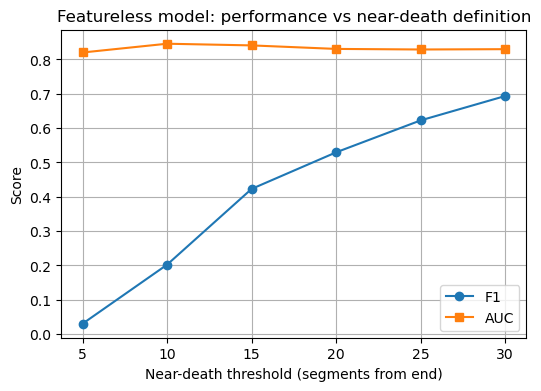

In [15]:
res_thr = results_thresholds_featureless.sort_values("threshold")

plt.figure()
plt.plot(res_thr["threshold"], res_thr["F1"], marker="o", label="F1")
plt.plot(res_thr["threshold"], res_thr["AUC"], marker="s", label="AUC")
plt.xlabel("Near-death threshold (segments from end)")
plt.ylabel("Score")
plt.title("Featureless model: performance vs near-death definition")
plt.legend()
plt.grid(True)
plt.show()
